### Отчет по лабораторной работе №4 "Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей"

In [336]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_boston
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline 
sns.set(style="ticks")

### подготовление датасета

In [337]:
# cторонняя компания по страхованию путешествий, базирующаяся в Сингапуре
data = pd.read_csv('лр4.csv', sep=',')

In [338]:
data.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


In [339]:
data.shape

(63326, 11)

In [340]:
data.dtypes

Agency                   object
Agency Type              object
Distribution Channel     object
Product Name             object
Claim                    object
Duration                  int64
Destination              object
Net Sales               float64
Commision (in value)    float64
Gender                   object
Age                       int64
dtype: object

In [341]:
# удаление пропусков
data = data.drop(columns='Gender')
data.isnull().sum()

Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Claim                   0
Duration                0
Destination             0
Net Sales               0
Commision (in value)    0
Age                     0
dtype: int64

In [342]:
# преобразование типов
cat_coll = []
for col in data.columns:
    if data[col].dtype == 'object':
        cat_coll.append(col)
en_cat = {}
for col in cat_coll:
    le = LabelEncoder()
    data[[col]] = le.fit_transform(data[col])  
    en_cat[col] = le

In [343]:
data.dtypes

Agency                    int64
Agency Type               int64
Distribution Channel      int64
Product Name              int64
Claim                     int64
Duration                  int64
Destination               int64
Net Sales               float64
Commision (in value)    float64
Age                       int64
dtype: object

In [344]:
# разделение выборки на обучающую и тестовую
# разделение исходного датасета на 2: с содержанием независимых и зависимых параметров соответственно
x, y = data[data.columns[range(9)]], data[data.columns[[9]]]

In [345]:
x.dtypes

Agency                    int64
Agency Type               int64
Distribution Channel      int64
Product Name              int64
Claim                     int64
Duration                  int64
Destination               int64
Net Sales               float64
Commision (in value)    float64
dtype: object

In [346]:
y.dtypes

Age    int64
dtype: object

In [348]:
test_size = 0.2
state = 42
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=test_size, random_state=state)
len(xtrain), len(xtest), len(ytrain), len(ytest)

(50660, 12666, 50660, 12666)

### обучение модели на произвольном гиперпараметре к

In [349]:
# значения возраста от 0 до 118, поэтому используется классифаер
print('количество классов:', len(data['Age'].unique()))

количество классов: 89


In [350]:
# обучение модели для произвольно заданного гиперпараметра к
k = 3
KNeighborsClassifierObj = KNeighborsClassifier(n_neighbors=k)
KNeighborsClassifierObj

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [351]:
# обучение модели для произвольно заданного гиперпараметра к
KNeighborsClassifierObj.fit(xtrain, ytrain.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [352]:
y_pred_train = KNeighborsClassifierObj.predict(xtrain)
y_pred_train

array([ 29,  22,  36, ...,  36,  36, 118])

In [353]:
y_pred_test = KNeighborsClassifierObj.predict(xtest)
y_pred_test

array([36, 31, 35, ..., 36, 26, 22])

In [354]:
ytest['Age'].values

array([36, 68, 36, ..., 36, 61, 36])

In [355]:
# оценивание качество модели классификации
print('train accuracy(%) {}'.format(accuracy_score(ytrain, y_pred_train) * 100))
print('train accuracy(%) {}'.format(accuracy_score(ytest, y_pred_test) * 100))

train accuracy(%) 53.45637583892617
train accuracy(%) 36.009789988946785


In [356]:
print('матрица ошибок: строки – истинное, столбцы – предсказанное')
print('train:\n', confusion_matrix(ytrain, y_pred_train))
print('test:\n', confusion_matrix(ytest, y_pred_test))

матрица ошибок: строки – истинное, столбцы – предсказанное
train:
 [[  0   0   0 ...   0   0   0]
 [  0   3   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 662]]
test:
 [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   1   0 ...   0   0 145]]


In [357]:
warnings.filterwarnings("ignore")
print(precision_score(ytrain, y_pred_train, average='weighted'))
print(precision_score(ytest, y_pred_test, average='weighted'))

0.5369837479887902
0.33407827460523043


In [358]:
warnings.filterwarnings("ignore")
print(f1_score(ytrain, y_pred_train, average='weighted'))
print(f1_score(ytest, y_pred, average='weighted'))

0.5001660212851098
0.3415855080250703


### оценивание качества с использованием кросс-валидации

In [359]:
# автоматически выбирается стратегия
warnings.filterwarnings("ignore")
scores = cross_val_score(KNeighborsClassifierObj, x, y.values.ravel(), cv=3)  # 3 фолда
scores  # дефолтная точность

array([0.36716828, 0.35783292, 0.34903691])

In [360]:
np.mean(scores)

0.35801270300862303

In [361]:
warnings.filterwarnings("ignore")
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}
scores = cross_validate(KNeighborsClassifierObj, x, y.values.ravel(), scoring=scoring, cv=3, return_train_score=True)
scores

{'fit_time': array([0.04443002, 0.03210306, 0.04179573]),
 'score_time': array([2.10332513, 2.17887306, 2.0072    ]),
 'test_precision': array([0.31211565, 0.3422917 , 0.33507145]),
 'train_precision': array([0.53744392, 0.53315717, 0.54169843]),
 'test_recall': array([0.36716828, 0.35783292, 0.34903691]),
 'train_recall': array([0.53991089, 0.53506278, 0.54381272]),
 'test_f1': array([0.33180252, 0.34690815, 0.33772616]),
 'train_f1': array([0.50527049, 0.49931282, 0.50993471])}

In [362]:
# стратегии кросс-валидации
# k-fold
scores = cross_val_score(KNeighborsClassifierObj, x, y.values.ravel(), cv=KFold(n_splits=8))
scores

array([0.42331986, 0.43292067, 0.40879232, 0.39527539, 0.36925215,
       0.34903992, 0.34996841, 0.13885028])

In [363]:
np.mean(scores)

0.3584273752321039

In [364]:
import warnings
warnings.filterwarnings("ignore")
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}
scores = cross_validate(KNeighborsClassifierObj, x, y.values.ravel(), scoring=scoring, cv=KFold(n_splits=8), return_train_score=True)
scores

{'fit_time': array([0.06199241, 0.04982924, 0.04527402, 0.05136704, 0.06994486,
        0.0535481 , 0.04695106, 0.05018783]),
 'score_time': array([0.78344965, 0.84904599, 0.78026295, 0.77187896, 0.88731003,
        0.84380794, 0.7876761 , 0.85170388]),
 'test_precision': array([0.4021957 , 0.42366685, 0.38153719, 0.40339355, 0.38272103,
        0.34907666, 0.34156568, 0.11046427]),
 'train_precision': array([0.52952924, 0.52388708, 0.52496116, 0.52909709, 0.52733944,
        0.53372504, 0.53298139, 0.56723542]),
 'test_recall': array([0.42331986, 0.43292067, 0.40879232, 0.39527539, 0.36925215,
        0.34903992, 0.34996841, 0.13885028]),
 'train_recall': array([0.52717921, 0.52051976, 0.52914636, 0.53046382, 0.53271973,
        0.53273777, 0.53653607, 0.56672863]),
 'test_f1': array([0.40850374, 0.42615716, 0.38998112, 0.39508761, 0.37264892,
        0.34484141, 0.34172742, 0.09835689]),
 'train_f1': array([0.49274776, 0.48825839, 0.4945263 , 0.49514389, 0.49691419,
        0.4990778

In [365]:
# ShuffleSplit
scores = cross_val_score(KNeighborsClassifierObj, x, y.values.ravel(), cv=ShuffleSplit(n_splits=8, test_size=0.2))
scores

array([0.36696668, 0.36641402, 0.37083531, 0.35843992, 0.37012474,
       0.36538765, 0.36759829, 0.36507185])

In [366]:
np.mean(scores)

0.36635480814779725

In [367]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}
scores = cross_validate(KNeighborsClassifierObj, x, y.values.ravel(), scoring=scoring, cv=ShuffleSplit(n_splits=8, test_size=0.2), return_train_score=True)
scores

{'fit_time': array([0.06298709, 0.0541029 , 0.05324697, 0.05118823, 0.04534888,
        0.04684019, 0.04511309, 0.04306793]),
 'score_time': array([1.47089791, 1.30955911, 1.23071313, 1.42082191, 1.34536815,
        1.29949474, 1.26875377, 1.23436594]),
 'test_precision': array([0.33898849, 0.33870243, 0.3558928 , 0.34316941, 0.33798552,
        0.34112644, 0.34278456, 0.34014289]),
 'train_precision': array([0.53597169, 0.53467763, 0.53991082, 0.53092839, 0.53209386,
        0.53129997, 0.53427949, 0.53462289]),
 'test_recall': array([0.36736144, 0.36617717, 0.37691457, 0.36625612, 0.36601926,
        0.36554556, 0.36980894, 0.36957208]),
 'train_recall': array([0.53385314, 0.53683379, 0.53624161, 0.53288591, 0.53452428,
        0.53553099, 0.53426767, 0.5358863 ]),
 'test_f1': array([0.34871206, 0.34699649, 0.35954662, 0.34954222, 0.34718676,
        0.34634674, 0.35090211, 0.35001448]),
 'train_f1': array([0.49956762, 0.5021287 , 0.50160143, 0.49783251, 0.49939902,
        0.4996139

In [368]:
# RepeatedKFold
scores = cross_val_score(KNeighborsClassifierObj, x, y.values.ravel(), cv=RepeatedKFold(n_splits=3, n_repeats=3), n_jobs=-1)
scores

array([0.36591028, 0.36373111, 0.37213379, 0.36785257, 0.36699986,
       0.36678037, 0.36382586, 0.36330475, 0.36606974])

In [369]:
np.mean(scores)

0.36628981310706

In [370]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}
scores = cross_validate(KNeighborsClassifierObj, x, y.values.ravel(), scoring=scoring, cv=RepeatedKFold(n_splits=3, n_repeats=3),
                        return_train_score=True, n_jobs=-1)
scores

{'fit_time': array([0.10314083, 0.11190295, 0.10741496, 0.07907581, 0.06042886,
        0.07871509, 0.08184385, 0.06535697, 0.06220388]),
 'score_time': array([3.79636908, 4.09066701, 4.01828909, 4.12634897, 4.16349101,
        4.7188592 , 4.81816101, 4.95011806, 3.35850906]),
 'test_precision': array([0.33423078, 0.33867559, 0.34067855, 0.34109225, 0.33969601,
        0.33419296, 0.33829907, 0.33442165, 0.3348406 ]),
 'train_precision': array([0.53540671, 0.53354868, 0.54068358, 0.5392429 , 0.53652721,
        0.54200505, 0.53068382, 0.53341513, 0.53575838]),
 'test_recall': array([0.35766735, 0.36875266, 0.36635399, 0.36628926, 0.36785257,
        0.3590108 , 0.36752096, 0.36718935, 0.36114269]),
 'train_recall': array([0.54210389, 0.54101428, 0.54085935, 0.53902456, 0.54165384,
        0.54230423, 0.53966412, 0.54132222, 0.53979345]),
 'test_f1': array([0.34075052, 0.3482693 , 0.34663884, 0.34844736, 0.34776344,
        0.34059248, 0.34767408, 0.34515737, 0.34333964]),
 'train_f1': 

### подбор гиперпараметра к с GridSearchCV и кросс-валидацией

In [371]:
n_neigh_values = range(1, 100, 5)
param = [{'n_neighbors': np.array(n_neigh_values)}]
class_grid = GridSearchCV(KNeighborsClassifier(), param, cv=KFold(n_splits=3), scoring='accuracy',
                          return_train_score=True,
                          n_jobs=-1,
                         )
class_grid.fit(x, y.values.ravel())
# считает ~4 мин

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'n_neighbors': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [372]:
class_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                     weights='uniform')

In [373]:
class_grid.best_score_

0.4316236616871427

In [374]:
class_grid.best_params_

{'n_neighbors': 31}

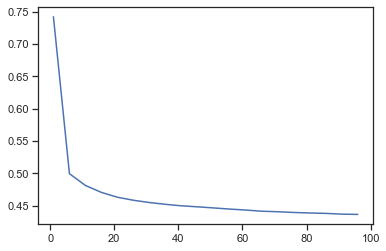

In [375]:
plt.plot(n_neigh_values, class_grid.cv_results_['mean_train_score'])

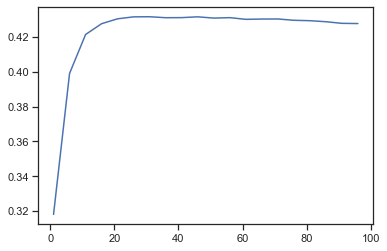

In [376]:
plt.plot(n_neigh_values, class_grid.cv_results_['mean_test_score'])

##### возрастание значения accuracy, оптимальный к = 31
#### повторение для выборок х, y

In [377]:
class_grid.best_estimator_.fit(xtrain, ytrain.values.ravel())

newypred_train = class_grid.best_estimator_.predict(xtrain)
newypred_test = class_grid.best_estimator_.predict(xtest)

print('train accuracy (%): {}'.format(accuracy_score(ytrain, y_pred_train) * 100))
print('test accuracy (%): {}'.format(accuracy_score(ytest, y_pred_test) * 100))

print('new accuracy train (%)): {}'.format(accuracy_score(ytrain, newypred_train) * 100))
print('new accuracy test (%): {}'.format(accuracy_score(ytest, newypred_test) * 100))

train accuracy (%): 53.45637583892617
test accuracy (%): 36.009789988946785
new accuracy train (%)): 45.64547966837742
new accuracy test (%): 42.79172588030949


### кривые обучения и валидации

In [379]:
def plotlearn_curve(estimator, title, x, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/a.kurganova/Library/Python/3.7/lib/python/site-packages/matplotlib/pyplot.py'>

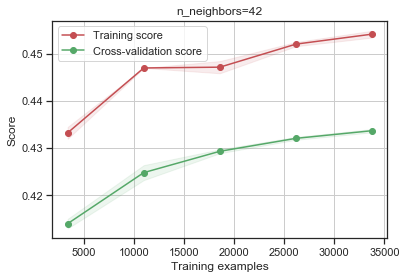

In [381]:
plotlearn_curve(class_grid.best_estimator_, 'n_neighbors=42',
                    xtrain, ytrain.values.ravel(), cv=KFold(n_splits=3))

In [382]:
def plotvalid_curve(estimator, title, x, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, x, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring,
        n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/a.kurganova/Library/Python/3.7/lib/python/site-packages/matplotlib/pyplot.py'>

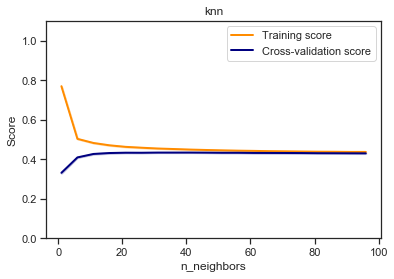

In [383]:
plotvalid_curve(KNeighborsClassifier(), 'knn', 
                      xtrain, ytrain.values.ravel(), 
                      param_name='n_neighbors', param_range=n_neigh_values, 
                      cv=KFold(n_splits=3), scoring="accuracy")